#Aulas 9 e 10

Igor Costa D'Oliveira - 11391446

Wesley Freitas Bernardino Araujo - 11808411

In [ ]:
url='http://www.lps.usp.br/hae/apostila/segm_eliret.zip'
import os; nomeArq=os.path.split(url)[1]
if not os.path.exists(nomeArq):
  print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
  os.system("wget -nc -U 'Firefox/50.0' "+url)
else:
  print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
print("Descompactando arquivos novos de",nomeArq)
os.system("unzip -u "+nomeArq)

Baixando o arquivo segm_eliret.zip para diretorio default /content
Descompactando arquivos novos de segm_eliret.zip


0

## Programa 2

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 16, 16, 40)        1040      
                                                                 
 dropout_37 (Dropout)        (None, 16, 16, 40)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 8, 8, 12)          12012     
                                                                 
 dropout_38 (Dropout)        (None, 8, 8, 12)          0         
                                                                 
 conv2d_80 (Conv2D)          (None, 4, 4, 12)          3612      
                                                                 
 dropout_39 (Dropout)        (None, 4, 4, 12)          0         
                                                                

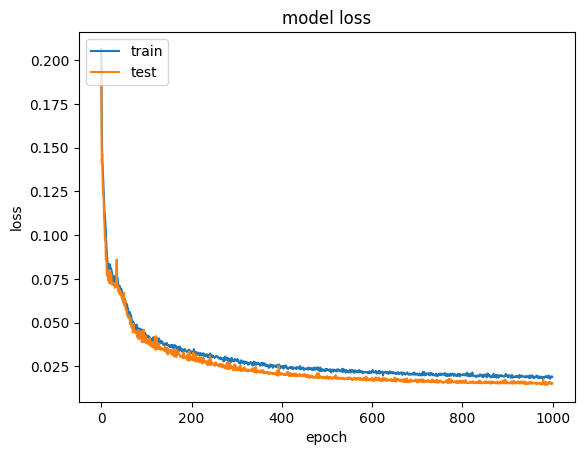

Training loss: 0.010223313234746456
Validation loss: 0.01513685006648302
Test loss: 0.016021577641367912


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#fcn-train1.py
#Treina rede fcn para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys; import cv2; import numpy as np; import matplotlib.pyplot as plt

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def leCsv(nomeDir,nomeArq):
  print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
  lines=arq.readlines(); arq.close(); n=len(lines)
  nl,nc = 32,32;
  AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
  i=0;
  for linha in lines:
    linha=linha.strip('\n'); linha=linha.split(';')
    AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),0)
    AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),0)
    i=i+1
  ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

#<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<

bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)
nl,nc = 32,32; input_shape = (nl,nc,1); batch_size = 20; epochs = 1000
model = Sequential()
model.add(Conv2D(40, kernel_size=(3,3), strides=1, activation='relu',
 padding='same', input_shape=input_shape)) #saida 16*16*40
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')) #saida 8*8*12
model.add(Dropout(0.25))
model.add(Conv2D(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')) #saida 4*4*12
model.add(Dropout(0.25))
model.add(Conv2DTranspose(12, kernel_size=(3,3), strides=1, activation='relu', padding='same')) #saida 8*8*12
model.add(Dropout(0.25))
model.add(Conv2DTranspose(40, kernel_size=(3,3), strides=1, activation='relu', padding='same')) #saida 16*16*40
model.add(Dropout(0.25))
model.add(Conv2DTranspose(1, kernel_size=(3,3), strides=1, padding='same')) #saida 32*32*1

from tensorflow.keras.utils import plot_model; plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()
opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx,vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn-train1.h5')

## Programa 3

1/1 [==============================] - 0s 482ms/step


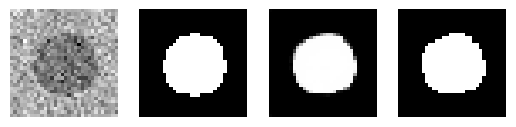

In [ ]:
#fcn-pred1.py
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys; from sys import argv
#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="077"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "fcn-train1.h5"
model = load_model(os.path.join(outDir,arquivoRede))
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)
qp=model.predict(qx); qp=qp.reshape(nl,nc) # entre 0 e +1
QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG); cv2.imwrite(os.path.join(outDir,outImgG),QPG)
QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)

## Segmentação Semântica

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Epoch 1/1000
5/5 - 2s - loss: 0.0253 - val_loss: 0.0177 - 2s/epoch - 480ms/step
Epoch 2/1000
5/5 - 0s - loss: 0.0253 - val_loss: 0.0181 - 96ms/epoch - 19ms/step
Epoch 3/1000
5/5 - 0s - loss: 0.0250 - val_loss: 0.0184 - 144ms/epoch - 29ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.0244 - val_loss: 0.0187 - 135ms/epoch - 27ms/step
Epoch 5/1000
5/5 - 0s - loss: 0.0248 - val_loss: 0.0185 - 95ms/epoch - 19ms/step
Epoch 6/1000
5/5 - 0s - loss: 0.0250 - val_loss: 0.0178 - 132ms/epoch - 26ms/step
Epoch 7/1000
5/5 - 0s - loss: 0.0256 - val_loss: 0.0175 - 96ms/epoch - 19ms/step
Epoch 8/1000
5/5 - 0s - loss: 0.0241 - val_loss: 0.0176 - 91ms/epoch - 18ms/step
Epoch 9/1000
5/5 - 0s - loss: 0.0248 - val_loss: 0.0174 - 136ms/epoch - 27ms/step
Epoch 10/1000
5/5 - 0s - loss: 0.0249 - val_loss: 0.0174 - 206ms/epoch - 41ms/step
Epoch 11/1000
5/5 - 0s - loss: 0.0232 - val_loss: 0.0181 - 300ms/epoch - 60ms/step
Epoch 12/1000
5/5 - 0s - loss: 0.0237 - val_lo

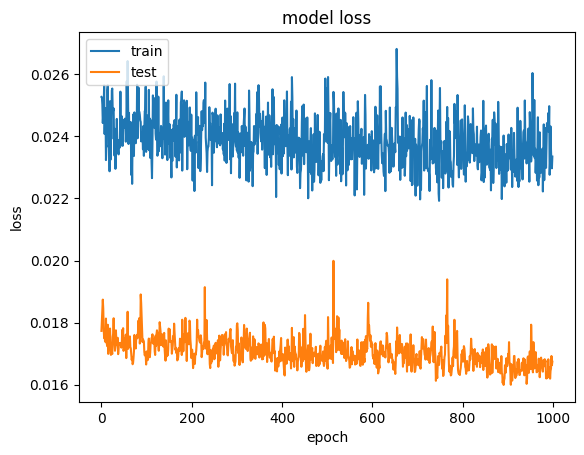

Training loss: 0.015542455948889256
Validation loss: 0.016744930297136307
Test loss: 0.017712783068418503


In [ ]:
#fcn_da1.py
#Treina rede fcn para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
import sys; import cv2; import numpy as np; import matplotlib.pyplot as plt

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def leCsv(nomeDir,nomeArq):
  print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
  lines=arq.readlines(); arq.close(); n=len(lines)
  nl,nc = 32,32;
  AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
  i=0;
  for linha in lines:
    linha=linha.strip('\n'); linha=linha.split(';')
    AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),0)
    AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),0)
    i=i+1
  ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

def fcn(input_shape = (32,32,1)):
  model = Sequential()
  model.add(Conv2D(40, kernel_size=(5,5), strides=2, activation='relu',padding='same',
  input_shape=input_shape)) #saida 16*16*40
  model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')) #saida 8*8*12
  model.add(Dropout(0.25))
  model.add(Conv2D(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')) #saida 4*4*12
  model.add(Conv2DTranspose(12, kernel_size=(5,5), strides=2, activation='relu', padding='same')) #saida 8*8*12
  model.add(Conv2DTranspose(40, kernel_size=(5,5), strides=2, activation='relu', padding='same')) #saida 16*16*40
  model.add(Dropout(0.25))
  model.add(Conv2DTranspose(1, kernel_size=(5,5), strides=2, padding='same')) #saida 32*32*1
  from tensorflow.keras.utils import plot_model;
  plot_model(model, to_file='fcn_da1.png', show_shapes=True)
  model.summary()
  return model
#<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)
nl,nc = 32,32; input_shape = (nl,nc,1)
aug_dict = dict(
  width_shift_range=0.70, #float: fraction of total width, if < 1, or pixels if >= 1.
  height_shift_range=0.70, #float: fraction of total height, if < 1, or pixels if >= 1.
  horizontal_flip=True, #Boolean. Randomly flip inputs horizontally.
  fill_mode='reflect'); #One of {"constant", "nearest", "reflect" or "wrap"}.
image_datagen = ImageDataGenerator(**aug_dict);
mask_datagen = ImageDataGenerator(**aug_dict);
seed=7; batch_size=20
image_generator = image_datagen.flow(ax, batch_size = batch_size, seed = seed);
mask_generator = mask_datagen.flow(ay, batch_size = batch_size, seed = seed);
def trainGenerator():
  train_generator=zip(image_generator,mask_generator)
  for (img,mask) in train_generator:
    mask[mask > 0.5] = 1; mask[mask <= 0.5] = 0
    yield(img,mask)
#model=fcn(input_shape)
model = load_model("fcn_da1.h5");
opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(trainGenerator(), steps_per_epoch=ax.shape[0]//batch_size,
 epochs=1000, verbose=2, validation_data=(vx,vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn_da1.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 40, 44, 40)        1040      
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 22, 12)        12012     
                                                                 
 dropout_5 (Dropout)         (None, 20, 22, 12)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 11, 12)        3612      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 20, 22, 12)        3612      
 Transpose)                                                      
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 40, 44, 40)        12040     
 Transpose)                                           

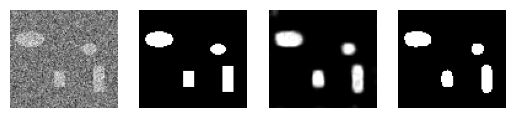

In [ ]:
#fcn_da1_pred.py
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys; from sys import argv
#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="maior2"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "fcn_da1.h5"
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)
model = fcn((nl,nc,1))
model.load_weights(os.path.join(outDir,arquivoRede))
qp=model.predict(qx)
qp=qp.reshape(nl,nc) # entre 0 e +1
QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG);
cv2.imwrite(os.path.join(outDir,outImgG),QPG)
QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)


## Unet

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
(None, 32, 32, 32)
(None, 32, 32, 32)
Model: "model_60"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_90 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_524 (Conv2D)         (None, 32, 32, 32)           320       ['input_90[0][0]']            
                                                                                                  
 conv2d_525 (Conv2D)         (None, 32, 32, 32)           9248      ['conv2d_524[0][0]']          
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 16, 16, 32)           0         ['conv2d_525[0][0]']        

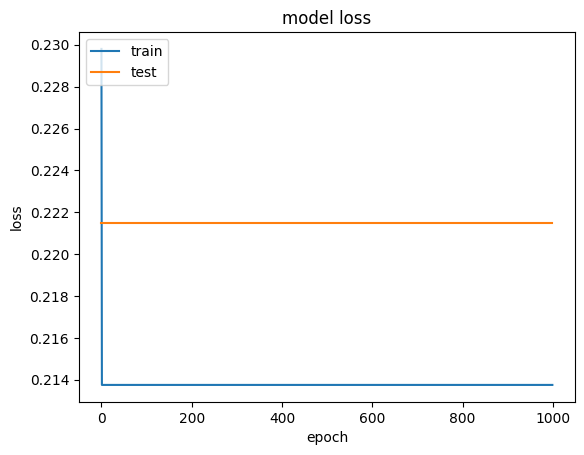

Training loss: 0.21375000476837158
Validation loss: 0.22150391340255737
Test loss: 0.24714843928813934


In [ ]:
#unet-train1.py
#Treina rede unet para segmentacao semantica de eliret
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np; np.random.seed(7); import sys
import tensorflow.keras as keras; from tensorflow.keras.models import *
from tensorflow.keras.layers import *; from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt

def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
def leCsv(nomeDir,nomeArq):
  print("Lendo: ",nomeArq); arq=open(os.path.join(nomeDir,nomeArq),"r")
  lines=arq.readlines(); arq.close(); n=len(lines)
  nl,nc = 32,32
  AX=np.empty((n,nl,nc),dtype='uint8'); AY=np.empty((n,nl,nc),dtype='uint8')
  i=0
  for linha in lines:
    linha=linha.strip('\n'); linha=linha.split(';')
    AX[i]=cv2.imread(os.path.join(nomeDir,linha[0]),0)
    AY[i]=cv2.imread(os.path.join(nomeDir,linha[1]),0)
    i=i+1
  ax= np.float32(AX)/255.0; ay= np.float32(AY)/255.0 #Entre 0 e +1
  ax = ax.reshape(n, nl, nc, 1); ay = ay.reshape(n, nl, nc, 1)
  return ax, ay

def unet(input_size = (32,32,1)):
  n=32
  inputs = Input(input_size) #32x32
  conv2 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(inputs)
  conv2 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #16x16
  conv3 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(pool2) #16x16
  conv3 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #8x8
  conv4 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(pool3) #8x8
  conv4 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) #4x4
  conv5 = Conv2D(8*n, 3, activation = 'relu', padding = 'same' )(pool4) #4x4
  conv5 = Conv2D(8*n, 3, activation = 'relu', padding = 'same' )(conv5) #4x4
  up6 = Conv2D(4*n, 2, activation = 'relu', padding = 'same'
  )(UpSampling2D(size = (2,2))(conv5)) #8x8
  merge6 = concatenate([conv4,up6], axis = 3) #8x8
  conv6 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(merge6)
  conv6 = Conv2D(4*n, 3, activation = 'relu', padding = 'same' )(conv6) #8x8
  up7 = Conv2D(2*n, 2, activation = 'relu', padding = 'same'
  )(UpSampling2D(size = (2,2))(conv6)) #16x16
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(merge7)
  conv7 = Conv2D(2*n, 3, activation = 'relu', padding = 'same' )(conv7) #16x16
  up8 = Conv2D(n, 2, activation = 'relu', padding = 'same'
  )(UpSampling2D(size = (2,2))(conv7)) #32x32
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(merge8)
  conv8 = Conv2D(n, 3, activation = 'relu', padding = 'same' )(conv8) #32x32
  conv9 = Conv2D(1, 1, activation = 'sigmoid', padding = 'same' )(conv8) #32x32

  model = Model(inputs = inputs, outputs = conv9)
  model.compile(optimizer = Adam(learning_rate=1e-3), loss = 'mean_squared_error')
  from tensorflow.keras.utils import plot_model
  plot_model(model, to_file='unet-train1.png', show_shapes=True)
  model.summary()
  return model
#<<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)
#Escolha entre comecar treino do zero ou continuar o treino de onde parou
model=unet()
#model = load_model("unet1.h5");
history=model.fit(ax, ay, batch_size=10, epochs=1000, verbose=2, validation_data=(vx,vy));
impHistoria(history); model.save("unet1.h5");
score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)


 ## Lição de casa aulas 9/10

### Item A: Test loss: 0.016718173399567604

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_97 (InputLayer)       [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_572 (Conv2D)         (None, 16, 16, 40)        1040      
                                                                 
 dropout_380 (Dropout)       (None, 16, 16, 40)        0         
                                                                 
 conv2d_573 (Conv2D)         (None, 8, 8, 12)          12012     
                                                                 
 dropout_381 (Dropout)       (None, 8, 8, 12)          0         
                                                                 
 conv2d_574 (Conv2D)         (None, 4, 4, 12)          3612      
                                                                 
 d

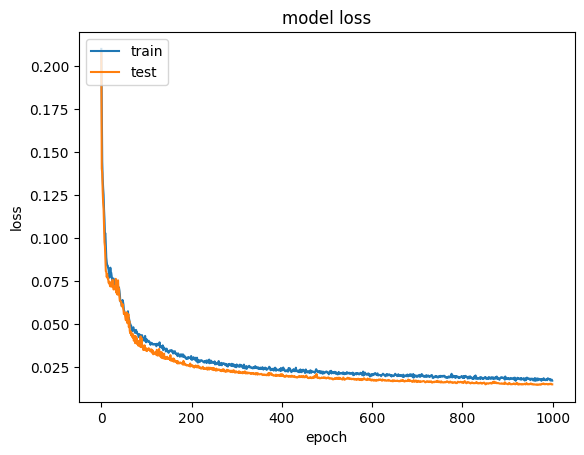

Training loss: 0.009642444550991058
Validation loss: 0.015178389847278595
Test loss: 0.016718173399567604


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def leCsv(nomeDir, nomeArq):
    print("Lendo: ", nomeArq)
    arq = open(os.path.join(nomeDir, nomeArq), "r")
    lines = arq.readlines()
    arq.close()
    n = len(lines)
    nl, nc = 32, 32
    AX = np.empty((n, nl, nc), dtype='uint8')
    AY = np.empty((n, nl, nc), dtype='uint8')
    i = 0
    for linha in lines:
        linha = linha.strip('\n')
        linha = linha.split(';')
        AX[i] = cv2.imread(os.path.join(nomeDir, linha[0]), 0)
        AY[i] = cv2.imread(os.path.join(nomeDir, linha[1]), 0)
        i = i + 1
    ax = np.float32(AX) / 255.0
    ay = np.float32(AY) / 255.0
    ax = ax.reshape(n, nl, nc, 1)
    ay = ay.reshape(n, nl, nc, 1)
    return ax, ay

# <<<<<<<<<<<<<< main <<<<<<<<<<<<<<

bdDir = "."
ax, ay = leCsv(bdDir, "treino.csv")
vx, vy = leCsv(bdDir, "valida.csv")
qx, qy = leCsv(bdDir, "teste.csv")
outDir = "."
os.chdir(outDir)
nl, nc = 32, 32
input_shape = (nl, nc, 1)
batch_size = 20
epochs = 1000

inputs = Input(shape=input_shape)
x = Conv2D(40, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(inputs)
x = Dropout(0.25)(x)
x = Conv2D(12, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2D(12, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2DTranspose(12, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
x = Conv2DTranspose(40, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(x)
x = Dropout(0.25)(x)
output_layer = Conv2DTranspose(1, kernel_size=(5, 5), strides=2, padding='same')(x)
model = keras.Model(inputs=inputs, outputs=output_layer)

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()
opt = optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history = model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx, vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0)
print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0)
print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0)
print('Test loss:', score)
model.save('fcn-train1.h5')

### Item B: Test loss: 0.00810623075813055

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_84 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_498 (Conv2D)         (None, 16, 16, 40)           1040      ['input_84[0][0]']            
                                                                                                  
 dropout_320 (Dropout)       (None, 16, 16, 40)           0         ['conv2d_498[0][0]']          
                                                                                                  
 conv2d_499 (Conv2D)         (None, 8, 8, 12)             12012     ['dropout_320[0][0]']         
                                   

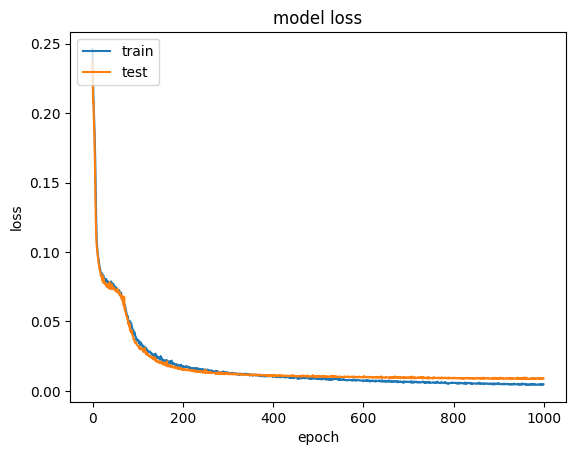

Training loss: 0.0011474838247522712
Validation loss: 0.008994031697511673
Test loss: 0.00810623075813055


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def leCsv(nomeDir, nomeArq):
    print("Lendo: ", nomeArq)
    arq = open(os.path.join(nomeDir, nomeArq), "r")
    lines = arq.readlines()
    arq.close()
    n = len(lines)
    nl, nc = 32, 32
    AX = np.empty((n, nl, nc), dtype='uint8')
    AY = np.empty((n, nl, nc), dtype='uint8')
    i = 0
    for linha in lines:
        linha = linha.strip('\n')
        linha = linha.split(';')
        AX[i] = cv2.imread(os.path.join(nomeDir, linha[0]), 0)
        AY[i] = cv2.imread(os.path.join(nomeDir, linha[1]), 0)
        i = i + 1
    ax = np.float32(AX) / 255.0
    ay = np.float32(AY) / 255.0
    ax = ax.reshape(n, nl, nc, 1)
    ay = ay.reshape(n, nl, nc, 1)
    return ax, ay

# <<<<<<<<<<<<<< main <<<<<<<<<<<<<<

bdDir = "."
ax, ay = leCsv(bdDir, "treino.csv")
vx, vy = leCsv(bdDir, "valida.csv")
qx, qy = leCsv(bdDir, "teste.csv")
outDir = "."
os.chdir(outDir)
nl, nc = 32, 32
input_shape = (nl, nc, 1)
batch_size = 20
epochs = 1000

inputs = Input(input_shape) #32x32
conv2 = Conv2D(40, kernel_size=(5,5), strides=2, activation = 'relu', padding = 'same' )(inputs) #16x16
conv2 = Dropout(0.25)(conv2)
conv3 = Conv2D(12, kernel_size=(5,5), strides=2, activation = 'relu', padding = 'same' )(conv2) #8x8
conv3 = Dropout(0.25)(conv3)
conv4 = Conv2D(12, kernel_size=(5,5), strides=2, activation = 'relu', padding = 'same' )(conv3) #4x4
conv4 = Dropout(0.25)(conv4)

up6     = Conv2DTranspose(12, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(conv4) #8x8
up6     = Dropout(0.25)(up6)
merge6  = concatenate([conv3,up6], axis = 3)
up7     = Conv2DTranspose(40, kernel_size=(5, 5), strides=2, activation='relu', padding='same')(merge6) #16x16
up7     = Dropout(0.25)(up7)
merge7  = concatenate([conv2,up7], axis = 3)
up8   = Conv2DTranspose(1, kernel_size=(5, 5), strides=2, activation='sigmoid', padding='same')(merge7)
model   = Model(inputs = inputs, outputs = up8)

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()
opt = optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history = model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx, vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0)
print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0)
print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0)
print('Test loss:', score)
model.save('fcn-train1.h5')

### Item C: Test loss: 0.006090530194342136

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_89 (InputLayer)       [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d_518 (Conv2D)         (None, 32, 32, 40)           400       ['input_89[0][0]']            
                                                                                                  
 conv2d_519 (Conv2D)         (None, 16, 16, 40)           14440     ['conv2d_518[0][0]']          
                                                                                                  
 dropout_345 (Dropout)       (None, 16, 16, 40)           0         ['conv2d_519[0][0]']          
                                   

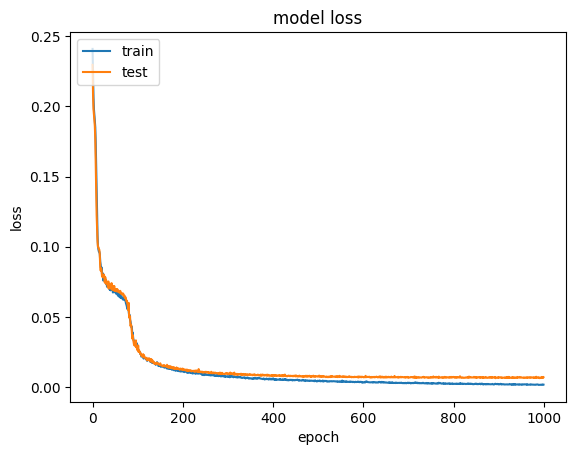

Training loss: 0.0003190413990523666
Validation loss: 0.0069725350476801395
Test loss: 0.006090530194342136


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def leCsv(nomeDir, nomeArq):
    print("Lendo: ", nomeArq)
    arq = open(os.path.join(nomeDir, nomeArq), "r")
    lines = arq.readlines()
    arq.close()
    n = len(lines)
    nl, nc = 32, 32
    AX = np.empty((n, nl, nc), dtype='uint8')
    AY = np.empty((n, nl, nc), dtype='uint8')
    i = 0
    for linha in lines:
        linha = linha.strip('\n')
        linha = linha.split(';')
        AX[i] = cv2.imread(os.path.join(nomeDir, linha[0]), 0)
        AY[i] = cv2.imread(os.path.join(nomeDir, linha[1]), 0)
        i = i + 1
    ax = np.float32(AX) / 255.0
    ay = np.float32(AY) / 255.0
    ax = ax.reshape(n, nl, nc, 1)
    ay = ay.reshape(n, nl, nc, 1)
    return ax, ay

# <<<<<<<<<<<<<< main <<<<<<<<<<<<<<

bdDir = "."
ax, ay = leCsv(bdDir, "treino.csv")
vx, vy = leCsv(bdDir, "valida.csv")
qx, qy = leCsv(bdDir, "teste.csv")
outDir = "."
os.chdir(outDir)
nl, nc = 32, 32
input_shape = (nl, nc, 1)
batch_size = 20
epochs = 1000

inputs = Input(input_shape) #32x32
conv2 = Conv2D(40, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(inputs) #16x16
conv2 = Conv2D(40, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv2) #16x16
conv2 = Dropout(0.25)(conv2)
conv3 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv2) #8x8
conv3 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv3) #8x8
conv3 = Dropout(0.25)(conv3)
conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv3) #4x4
conv4 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv4) #4x4
conv4 = Dropout(0.25)(conv4)

up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv4) #8x8
up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up6) #8x8
up6     = Dropout(0.25)(up6)
merge6  = concatenate([conv3,up6], axis = 3)
up7     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge6) #8x8
up7     = Conv2DTranspose(40, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up7) #16x16
up7     = Dropout(0.25)(up7)
merge7  = concatenate([conv2,up7], axis = 3)
up8     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge7) #8x8
up8   = Conv2DTranspose(1, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same')(up8)
model   = Model(inputs = inputs, outputs = up8)

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='fcn-train1.png', show_shapes=True)
model.summary()
opt = optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history = model.fit(ax, ay, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(vx, vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0)
print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0)
print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0)
print('Test loss:', score)
model.save('fcn-train1.h5')

## Lição de casa extra: Test loss: 0.008722151629626751

Lendo:  treino.csv
Lendo:  valida.csv
Lendo:  teste.csv
Epoch 1/1000
5/5 - 5s - loss: 0.2466 - val_loss: 0.2411 - 5s/epoch - 908ms/step
Epoch 2/1000
5/5 - 0s - loss: 0.2298 - val_loss: 0.2182 - 125ms/epoch - 25ms/step
Epoch 3/1000
5/5 - 0s - loss: 0.1903 - val_loss: 0.2190 - 127ms/epoch - 25ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.1867 - val_loss: 0.2248 - 116ms/epoch - 23ms/step
Epoch 5/1000
5/5 - 0s - loss: 0.1841 - val_loss: 0.2108 - 128ms/epoch - 26ms/step
Epoch 6/1000
5/5 - 0s - loss: 0.1743 - val_loss: 0.2020 - 122ms/epoch - 24ms/step
Epoch 7/1000
5/5 - 0s - loss: 0.1776 - val_loss: 0.2009 - 135ms/epoch - 27ms/step
Epoch 8/1000
5/5 - 0s - loss: 0.1735 - val_loss: 0.2044 - 121ms/epoch - 24ms/step
Epoch 9/1000
5/5 - 0s - loss: 0.1749 - val_loss: 0.2030 - 113ms/epoch - 23ms/step
Epoch 10/1000
5/5 - 0s - loss: 0.1714 - val_loss: 0.1990 - 135ms/epoch - 27ms/step
Epoch 11/1000
5/5 - 0s - loss: 0.1701 - val_loss: 0.1998 - 155ms/epoch - 31ms/step
Epoch 12/1000
5/5 - 0s - loss: 0.1684 - va

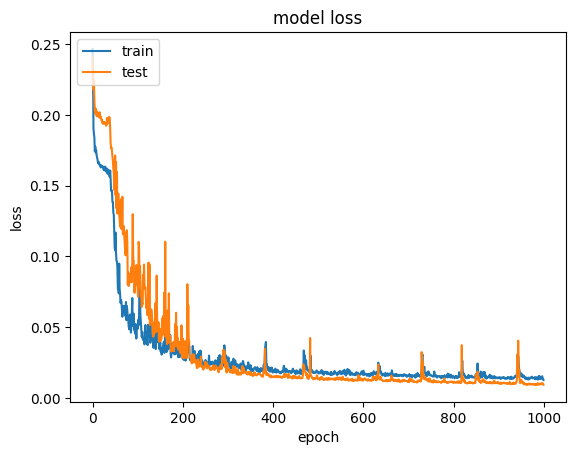

Training loss: 0.007639503572136164
Validation loss: 0.009383111260831356
Test loss: 0.008722151629626751


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

def impHistoria(history):
    print(history.history.keys())
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def leCsv(nomeDir, nomeArq):
    print("Lendo: ", nomeArq)
    arq = open(os.path.join(nomeDir, nomeArq), "r")
    lines = arq.readlines()
    arq.close()
    n = len(lines)
    nl, nc = 32, 32
    AX = np.empty((n, nl, nc), dtype='uint8')
    AY = np.empty((n, nl, nc), dtype='uint8')
    i = 0
    for linha in lines:
        linha = linha.strip('\n')
        linha = linha.split(';')
        AX[i] = cv2.imread(os.path.join(nomeDir, linha[0]), 0)
        AY[i] = cv2.imread(os.path.join(nomeDir, linha[1]), 0)
        i = i + 1
    ax = np.float32(AX) / 255.0
    ay = np.float32(AY) / 255.0
    ax = ax.reshape(n, nl, nc, 1)
    ay = ay.reshape(n, nl, nc, 1)
    return ax, ay

# <<<<<<<<<<<<<< main <<<<<<<<<<<<<<

bdDir = "."
ax, ay = leCsv(bdDir,"treino.csv")
vx, vy = leCsv(bdDir,"valida.csv")
qx, qy = leCsv(bdDir,"teste.csv")
outDir = "."; os.chdir(outDir)
nl,nc = 32,32; input_shape = (nl,nc,1)
aug_dict = dict(
  width_shift_range=0.70, #float: fraction of total width, if < 1, or pixels if >= 1.
  height_shift_range=0.70, #float: fraction of total height, if < 1, or pixels if >= 1.
  horizontal_flip=True, #Boolean. Randomly flip inputs horizontally.
  fill_mode='reflect'); #One of {"constant", "nearest", "reflect" or "wrap"}.
image_datagen = ImageDataGenerator(**aug_dict);
mask_datagen = ImageDataGenerator(**aug_dict);
seed=7; batch_size=20
image_generator = image_datagen.flow(ax, batch_size = batch_size, seed = seed);
mask_generator = mask_datagen.flow(ay, batch_size = batch_size, seed = seed);
def trainGenerator():
  train_generator=zip(image_generator,mask_generator)
  for (img,mask) in train_generator:
    mask[mask > 0.5] = 1; mask[mask <= 0.5] = 0
    yield(img,mask)

inputs = Input(input_shape) #32x32
conv2 = Conv2D(40, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(inputs) #16x16
conv2 = Conv2D(40, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv2) #16x16
conv2 = Dropout(0.25)(conv2)
conv3 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv2) #8x8
conv3 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv3) #8x8
conv3 = Dropout(0.25)(conv3)
conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv3) #4x4
conv4 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv4) #4x4
conv4 = Dropout(0.25)(conv4)

up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv4) #8x8
up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up6) #8x8
up6     = Dropout(0.25)(up6)
merge6  = concatenate([conv3,up6], axis = 3)
up7     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge6) #8x8
up7     = Conv2DTranspose(40, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up7) #16x16
up7     = Dropout(0.25)(up7)
merge7  = concatenate([conv2,up7], axis = 3)
up8     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge7) #8x8
up8   = Conv2DTranspose(1, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same')(up8)
model   = Model(inputs = inputs, outputs = up8)

opt=optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
history=model.fit(trainGenerator(), steps_per_epoch=ax.shape[0]//batch_size,
 epochs=1000, verbose=2, validation_data=(vx,vy))
impHistoria(history)
score = model.evaluate(ax, ay, verbose=0); print('Training loss:', score)
score = model.evaluate(vx, vy, verbose=0); print('Validation loss:', score)
score = model.evaluate(qx, qy, verbose=0); print('Test loss:', score)
model.save('fcn_da1.h5')

1/1 [==============================] - 0s 277ms/step


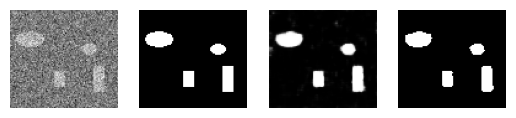

In [ ]:
#fcn_da1_pred.py
#Faz segmentacao semantica usando rede gerada pelo fcn-train1.py
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import cv2; import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Conv2D, Conv2DTranspose
from tensorflow.keras import optimizers
import sys; from sys import argv
#<<<<<<<<<<<<<<<<<<< main <<<<<<<<<<<<<<<<<<<<<<
bdDir = "."
outDir = "."; os.chdir(outDir)
nome="maior2"
inImgX = nome+"x.png"; inImgY = nome+"y.png"
outImgG =nome+"g.png"; outImgB =nome+"b.png"
arquivoRede = "fcn_da1.h5"
QX=cv2.imread(os.path.join(bdDir,inImgX),0)
QY=cv2.imread(os.path.join(bdDir,inImgY),0)
nl=QX.shape[0]; nc=QX.shape[1]
qx=np.float32(QX)/255.0 #Entre 0 e +1
qx=qx.reshape(1, nl, nc, 1)

def fcn(input_shape):
  inputs = Input(input_shape) #32x32
  conv2 = Conv2D(40, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(inputs) #16x16
  conv2 = Conv2D(40, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv2) #16x16
  conv2 = Dropout(0.25)(conv2)
  conv3 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv2) #8x8
  conv3 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv3) #8x8
  conv3 = Dropout(0.25)(conv3)
  conv4 = Conv2D(12, kernel_size=(3,3), strides=1, activation = 'relu', padding = 'same' )(conv3) #4x4
  conv4 = Conv2D(12, kernel_size=(3,3), strides=2, activation = 'relu', padding = 'same' )(conv4) #4x4
  conv4 = Dropout(0.25)(conv4)

  up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(conv4) #8x8
  up6     = Conv2DTranspose(12, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up6) #8x8
  up6     = Dropout(0.25)(up6)
  merge6  = concatenate([conv3,up6], axis = 3)
  up7     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge6) #8x8
  up7     = Conv2DTranspose(40, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(up7) #16x16
  up7     = Dropout(0.25)(up7)
  merge7  = concatenate([conv2,up7], axis = 3)
  up8     = Conv2DTranspose(12, kernel_size=(3, 3), strides=1, activation='relu', padding='same')(merge7) #8x8
  up8   = Conv2DTranspose(1, kernel_size=(3, 3), strides=2, activation='sigmoid', padding='same')(up8)
  model   = Model(inputs = inputs, outputs = up8)
  return model

model = fcn((nl,nc,1))
model.load_weights(os.path.join(outDir,arquivoRede))
qp=model.predict(qx)
qp=qp.reshape(nl,nc) # entre 0 e +1
QPG=255.0*qp; QPG=np.clip(QPG,0,255) # Entre 0 e 255
QPG=np.uint8(QPG);
cv2.imwrite(os.path.join(outDir,outImgG),QPG)
QPB=np.zeros((nl,nc),dtype='uint8'); QPB[ qp>=0.5 ] = 255
cv2.imwrite(os.path.join(outDir,outImgB),QPB)
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1,4,1); plt.imshow(QX,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,2); plt.imshow(QY,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,3); plt.imshow(QPG,cmap="gray"); plt.axis('off')
f.add_subplot(1,4,4); plt.imshow(QPB,cmap="gray"); plt.axis('off')
plt.show(block=True)
